In [3]:
from tensorflow.python.client import device_lib
import tensorflow as tf

# List all local devices
devices = device_lib.list_local_devices()
for d in devices:
    if d.device_type == 'GPU':
        print(f"GPU name: {d.name}, memory: {d.memory_limit / 1024**2:.1f} MB")
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))


GPU name: /device:GPU:0, memory: 6144.1 MB
GPU name: /device:GPU:1, memory: 6606.4 MB
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


I0000 00:00:1747892144.668613    3382 gpu_device.cc:2019] Created device /device:GPU:0 with 6144 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:02:00.0, compute capability: 8.6
I0000 00:00:1747892144.670865    3382 gpu_device.cc:2019] Created device /device:GPU:1 with 6606 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5
I0000 00:00:1747892144.704578    3382 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6144 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:02:00.0, compute capability: 8.6
I0000 00:00:1747892144.706610    3382 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6606 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


In [14]:
import numpy as np # 선형 대수 연산용
import pandas as pd # 데이터 처리, CSV 파일 입출력용 (예: pd.read_csv)
# 현재 디렉토리(/kaggle/working/)에는 최대 20GB까지 파일을 저장할 수 있으며,
# "Save & Run All" 기능을 사용하여 버전을 만들 때 출력 결과로 보존됩니다
# 또한 /kaggle/temp/ 디렉토리에는 임시 파일을 저장할 수 있으나,
# 이 파일들은 현재 세션이 종료되면 저장되지 않습니다

In [15]:
import os  # 운영 체제와 상호작용하기 위한 모듈 (예: 파일 경로 설정, 디렉터리 생성 등)

import tensorflow as tf  # 구글에서 만든 딥러닝 라이브러리 TensorFlow를 불러옴
from tensorflow import keras  # TensorFlow 안에 포함된 고수준 딥러닝 API인 Keras를 불러옴

from tensorflow.keras.optimizers import Adam  # 모델 학습 시 사용하는 최적화 알고리즘 중 하나인 Adam 불러옴

from sklearn.model_selection import train_test_split  # 데이터를 학습용과 테스트용으로 나누기 위한 함수

from tensorflow.keras.metrics import categorical_crossentropy  # 다중 분류 문제에서 사용되는 손실 함수 (정답과 예측 차이 계산)

from tensorflow.keras.models import Model, load_model, Sequential  # Keras의 모델 관련 기능 불러옴 (Model: 기본 모델, load_model: 저장된 모델 불러오기, Sequential: 레이어를 순서대로 쌓는 모델)

from sklearn.metrics import confusion_matrix, classification_report  # 모델의 성능 평가에 사용되는 도구 (혼동 행렬, 정확도 등)

from tensorflow.keras.preprocessing.image import ImageDataGenerator  # 이미지 데이터를 증강(늘리기)하기 위한 도구 (회전, 확대, 이동 등으로 이미지 다양화)

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization  
# Conv2D: 이미지 특징을 추출하는 필터 레이어  
# MaxPooling2D: 이미지 크기를 줄이면서 중요한 특징만 남기는 레이어  
# Flatten: 2D 이미지를 1D로 펴주는 레이어 (Dense 레이어 입력을 위해 필요)  
# Dense: 완전 연결된 레이어 (신경망의 기본 구조)  
# Activation: 활성화 함수 적용 (예: ReLU, Softmax 등)  
# Dropout: 과적합을 막기 위해 일부 뉴런을 학습 중 무시하는 기법  
# BatchNormalization: 학습 속도 향상 및 안정화를 위한 정규화 레이어


In [1]:
import os  # 운영체제 기능을 사용하기 위한 모듈을 불러옴 (예: 폴더 경로 탐색 등)

# 데이터셋이 저장된 폴더 경로를 지정함
fpath = "./archive/train"
dataset_path = fpath  # 위에서 지정한 경로를 dataset_path 변수에 저장

# 폴더 안에 있는 하위 디렉토리 목록을 가져옴 (각 디렉토리는 한 개의 클래스에 해당됨)
class_folders = [f.name for f in os.scandir(dataset_path) if f.is_dir()]  
# 예: 'apple', 'tomato'라는 폴더가 있다면 ['apple', 'tomato'] 반환

# 클래스(분류할 대상)의 개수를 계산함
num_classes = len(class_folders)  # 위에서 찾은 폴더 개수만큼 클래스 수가 정해짐

# 클래스의 개수를 출력함
print("Number of classes:", num_classes)  # 예: Number of classes: 2

# 클래스 이름들을 리스트로 저장 (예: ['apple', 'tomato'])
target_names = class_folders  # 예측 결과를 사람이 이해할 수 있도록 이름으로 저장

# 클래스 이름 리스트를 출력함
print("Target Names:", target_names)  # 예: Target Names: ['apple', 'tomato']


Number of classes: 2
Target Names: ['apples', 'tomatoes']


In [2]:
img_size = 224
batch_size =50
fpath = "./archive/train"
ffpath="./archive/test"

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # 이미지 데이터 증강을 위한 도구를 불러옴 (회전, 확대, 정규화 등)

# 'fpath'는 학습용 데이터셋 폴더 경로이고, 'batch_size'는 한 번에 불러올 이미지 수라고 가정

# 학습 및 검증 데이터를 전처리하고, 이미지 증강을 설정함
datagen = ImageDataGenerator(
    rescale=1/255.,              # 픽셀 값을 0~255 → 0~1로 정규화 (모델 학습에 적합하게 만듦)
    zoom_range=0.2,              # 이미지를 랜덤하게 최대 20%까지 확대
    rotation_range=30,          # 이미지를 -30도~+30도 사이로 회전시킴
    validation_split=0.2,       # 전체 데이터 중 20%는 검증용(validation)으로 사용
    horizontal_flip=True        # 이미지를 좌우로 뒤집는 데이터 증강 적용
)

# 학습용 이미지 생성기 설정
train_gen = datagen.flow_from_directory(
    fpath,                      # 이미지가 저장된 최상위 폴더 경로
    target_size=(224, 224),     # 모든 이미지를 224x224 크기로 맞춤 (모델 입력 크기)
    subset="training",          # 전체 중 80%를 학습용으로 사용
    class_mode='categorical',   # 다중 클래스 분류이므로 one-hot 인코딩된 label 사용
    batch_size=batch_size       # 한 번에 불러올 이미지 개수 (성능과 속도에 영향을 줌)
)

# 검증용 이미지 생성기 설정
valid_gen = datagen.flow_from_directory(
    fpath,                      # 같은 폴더에서 검증용 이미지도 불러옴
    target_size=(224, 224),     # 이미지 크기 통일
    batch_size=batch_size,      # 배치 크기 동일하게 설정
    subset='validation',        # 전체 중 20%를 검증용으로 사용
    class_mode='categorical'    # 다중 분류를 위한 one-hot 인코딩
)

# 테스트용 데이터 생성기 설정
test_gen = ImageDataGenerator(rescale=1/255.).flow_from_directory(
    ffpath,                     # 테스트 이미지가 저장된 폴더 경로 (오타 주의: fpath와 다름)
    target_size=(224, 224),     # 테스트 이미지도 크기를 동일하게 맞춤
    batch_size=50,              # 한 번에 50장의 이미지를 불러옴
    class_mode='categorical',   # 다중 클래스 분류용 설정
    shuffle=False               # 테스트에서는 결과를 정확히 비교해야 하므로 셔플 비활성화
)


2025-05-22 07:32:39.629265: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747899159.641220   28387 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747899159.644867   28387 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747899159.653895   28387 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747899159.653907   28387 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747899159.653909   28387 computation_placer.cc:177] computation placer alr

Found 236 images belonging to 2 classes.
Found 58 images belonging to 2 classes.
Found 97 images belonging to 2 classes.


In [4]:
import tensorflow as tf  # 텐서플로(TensorFlow)는 딥러닝을 구현할 수 있는 구글의 오픈소스 프레임워크
from tensorflow.keras.models import Sequential  # 레이어를 순차적으로 쌓을 수 있는 간단한 모델 형식
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization  # 완전 연결층(Dense), 과적합 방지용 드롭아웃, 학습 안정화를 위한 배치 정규화 레이어
from tensorflow.keras.callbacks import ModelCheckpoint  # 모델을 저장할 수 있는 콜백 함수 불러오기

# train_gen과 valid_gen은 이미지 데이터 생성기라고 가정 (학습용과 검증용 이미지)

img_size = (224, 224)  # 이미지의 크기를 224x224로 설정 (입력으로 통일된 크기 사용)
channels = 3  # 컬러 이미지이므로 R, G, B 채널로 총 3개
img_shape = (img_size[0], img_size[1], channels)  # 전체 입력 이미지의 형태 (224, 224, 3)

class_count = len(list(train_gen.class_indices.keys()))  # 분류해야 할 클래스(카테고리) 수를 계산함

# 사전 학습된 모델(EfficientNetB3)을 불러옴
base_model = tf.keras.applications.EfficientNetB3(
    include_top=False,  # 기본 모델의 마지막 분류 레이어는 제거
    weights="imagenet",  # ImageNet 데이터로 학습된 가중치를 사용
    input_shape=img_shape,  # 입력 이미지의 크기를 지정
    pooling='max'  # 마지막 특성 맵을 전역 최대값으로 압축
)

# 사전학습된 레이어들의 가중치를 고정시켜 학습되지 않도록 설정
for layer in base_model.layers:
    layer.trainable = False  # 가중치 업데이트를 하지 않도록 설정 (특징 추출용으로만 사용)

# 전체 모델 구성: 사전학습 모델 위에 새 레이어들을 쌓아 최종 분류 모델 생성
model = Sequential([
    base_model,                         # 사전학습된 베이스 모델
    BatchNormalization(),              # 학습 안정화를 위한 배치 정규화
    Dense(256, activation='relu'),     # 은닉층 256개 뉴런, 활성화 함수는 ReLU
    Dropout(0.3),                      # 학습 중 30% 뉴런을 비활성화하여 과적합 방지
    Dense(64, activation='relu'),      # 또 다른 은닉층 64개 뉴런
    Dropout(0.3),                      # 과적합 방지를 위한 드롭아웃
    Dense(class_count, activation='softmax')  # 출력층: 클래스 수만큼 뉴런, 확률값을 출력하기 위해 softmax 사용
])

# 모델 학습을 위한 최적화 알고리즘(Adam) 설정
optimizer = tf.keras.optimizers.Adam()

# 모델 컴파일: 손실 함수, 최적화 알고리즘, 평가 지표 설정
model.compile(
    optimizer=optimizer,                     # 위에서 정의한 Adam 최적화기 사용
    loss='categorical_crossentropy',         # 다중 분류이므로 범주형 크로스 엔트로피 사용
    metrics=['accuracy']                     # 모델 성능을 정확도로 평가
)

# 모델을 저장할 파일 경로 지정
filepath = 'best_model.h5'  # 가장 성능이 좋은 모델을 이 파일명으로 저장함

# 검증 정확도를 기준으로 가장 좋은 모델만 저장하는 콜백 정의
checkpoint = ModelCheckpoint(
    filepath,                # 저장 파일 경로
    monitor='val_accuracy', # 검증 데이터의 정확도를 기준으로 판단
    verbose=1,              # 저장 여부를 콘솔에 출력함
    save_best_only=True,    # 정확도가 가장 높을 때만 저장
    mode='max'              # 최대값이 가장 좋은 성능으로 간주
)

# 모델을 학습하고, 콜백을 적용하여 최적의 모델을 자동으로 저장함
history = model.fit(
    x=train_gen,            # 학습 데이터 생성기
    epochs=100,              # 전체 데이터셋을 100번 반복 학습
    verbose=1,              # 학습 과정을 자세히 출력
    validation_data=valid_gen,  # 검증용 데이터 생성기
    callbacks=[checkpoint]      # 체크포인트 콜백을 적용하여 모델 저장
)


I0000 00:00:1747899166.307652   28387 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6144 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:02:00.0, compute capability: 8.6
I0000 00:00:1747899166.312204   28387 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6606 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5
/home/kdh/anaconda3/envs/KSEB/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1747899177.560860   28515 service.cc:152] XLA service 0x73497401c0d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747899177.560889   28515 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
I0000 00:00:1747899177.560891   28515 service.cc:160]   StreamExecutor device (1): NVIDIA GeForce RTX 2080 SUPER, Compute Capability 7.5
2025-05-22 07:32:57.900634: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747899179.660061   28515 cuda_dnn.cc:529] Loaded cuDNN version 90501


1/5 ━━━━━━━━━━━━━━━━━━━━ 1:33 23s/step - accuracy: 0.4400 - loss: 1.3353

I0000 00:00:1747899191.869297   28515 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4864 - loss: 1.3478   

KeyboardInterrupt: 

In [5]:
import tensorflow as tf

# Load the .h5 model
model = tf.keras.models.load_model('best_model.h5')

# Save in SavedModel format
model.export('EfficientNetB3_directory')


INFO:tensorflow:Assets written to: EfficientNetB3_directory/assets


INFO:tensorflow:Assets written to: EfficientNetB3_directory/assets


Saved artifact at 'EfficientNetB3_directory'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_5')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  126750783785680: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  126750783790096: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  126750783790288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126750783789520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126750783785872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126750783791056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126750783791632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126750783789136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126750783788752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126750783791440: TensorSpec(shape=(), dtype=tf.resource, 

In [6]:
import tensorflow as tf  # 딥러닝 프레임워크인 텐서플로(TensorFlow)를 불러옴
from tensorflow.keras.models import load_model, Model  # 저장된 모델을 불러오는 함수와 모델 클래스 사용
from tensorflow.keras.layers import Input, Average  # 모델의 입력 레이어와 평균 연산 레이어 사용 (현재는 사용되지 않음)

# 학습이 완료된 모델(best_model.h5)을 불러옴
model = load_model('best_model.h5')  # 저장된 최적의 모델 파일을 불러와서 메모리에 로드함

# 학습 데이터셋을 사용하여 성능 평가 (손실과 정확도 출력)
train_score = model.evaluate(train_gen, steps=len(train_gen), verbose=1)
# steps: 전체 데이터를 한 번씩 평가하기 위한 배치 수
# verbose=1은 진행 상황을 출력하겠다는 의미

# 검증 데이터셋을 사용하여 모델 성능 평가
valid_score = model.evaluate(valid_gen, steps=len(valid_gen), verbose=1)

# 테스트 데이터셋을 사용하여 최종 모델 성능 평가
test_score = model.evaluate(test_gen, steps=len(test_gen), verbose=1)

# 학습 데이터의 손실(loss) 값 출력
print("Train Loss: ", train_score[0])
# 학습 데이터의 정확도(accuracy) 출력
print("Train Accuracy: ", train_score[1])

# 구분선 출력
print('-' * 20)

# 검증 데이터의 손실(loss) 값 출력
print("Validation Loss: ", valid_score[0])
# 검증 데이터의 정확도 출력
print("Validation Accuracy: ", valid_score[1])

# 구분선 출력
print('-' * 20)

# 테스트 데이터의 손실 값 출력
print("Test Loss: ", test_score[0])
# 테스트 데이터의 정확도 출력
print("Test Accuracy: ", test_score[1])


2025-05-22 07:33:54.247128: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3286', 156 bytes spill stores, 156 bytes spill loads



4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.5296 - loss: 0.6915

2025-05-22 07:33:59.198115: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3286', 156 bytes spill stores, 156 bytes spill loads



5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5395 - loss: 0.6888  
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.5611 - loss: 0.6848   
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 0.5542

/home/kdh/anaconda3/envs/KSEB/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-05-22 07:34:09.408145: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3286', 156 bytes spill stores, 156 bytes spill loads



2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.7045 - loss: 0.6412   
Train Loss:  0.6834185719490051
Train Accuracy:  0.5593220591545105
--------------------
Validation Loss:  0.6877433061599731
Validation Accuracy:  0.5517241358757019
--------------------
Test Loss:  0.6847529411315918
Test Accuracy:  0.5567010045051575


In [16]:
model = load_model('best_model.h5')  
# 학습이 끝난 상태의 모델을 로드함

preds = model.predict(test_gen)  
# 테스트 데이터(test_gen)를 입력으로 하여 예측 수행  
# predict_generator는 여러 장의 이미지를 순차적으로 예측할 수 있게 해줌  
# 결과는 각 이미지에 대한 클래스별 확률값 배열로 반환됨

y_pred = np.argmax(preds, axis=1)  
# 가장 높은 확률값을 가진 클래스의 인덱스를 뽑아냄 → 최종 예측 클래스  
# 예: [0.1, 0.7, 0.2] → 1 (두 번째 클래스가 가장 높은 확률)

print(y_pred)  
# 예측 결과를 출력 (각 이미지가 어떤 클래스라고 판단되었는지를 숫자로 보여줌)


2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [17]:
import itertools  # 반복 가능한 객체를 조합하거나 순열을 만들 수 있는 유용한 도구 모음
import matplotlib.pyplot as plt  # 그래프를 그릴 수 있는 시각화 도구

# 혼동 행렬(Confusion Matrix)을 시각화하는 함수 정의
# cm: Confusion Matrix 데이터(행렬)
# classes: 클래스 이름 리스트 
# normalize: True로 설정 시, 퍼센트로 표시되도록 정규화
# title: plot의 이름
# cmap: 색상 맵 
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 10))  # 그래프 크기를 10x10 인치로 설정

    plt.imshow(cm, interpolation='nearest', cmap=cmap)  # 행렬 데이터를 이미지처럼 시각화, 색상 맵 사용
    plt.title(title)  # 그래프 제목 설정
    plt.colorbar()  # 색상 기준 바(legend) 추가

    tick_marks = np.arange(len(classes))  # 클래스 개수만큼 눈금 위치 생성
    plt.xticks(tick_marks, classes, rotation=45)  # X축 눈금에 클래스 이름 표시 (45도 회전)
    plt.yticks(tick_marks, classes)  # Y축 눈금에도 클래스 이름 표시

    if normalize:
        # normalize=True일 경우, 정규화된 비율로 행렬값을 변경
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized Confusion Matrix')  # 정규화된 혼동 행렬이라는 안내 출력
    else:
        print('Confusion Matrix, Without Normalization')  # 정규화하지 않은 혼동 행렬이라는 안내 출력

    print(cm)  # 실제 숫자 데이터(행렬 값) 출력

    thresh = cm.max() / 2.  # 색상 대비를 위해 기준값 설정 (최댓값의 절반)

    # 모든 셀에 값을 텍스트로 삽입 (값이 크면 흰 글씨, 작으면 검정 글씨)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()  # 그래프 요소 간 간격 자동 조절
    plt.ylabel('True Label')  # Y축 라벨: 실제 클래스
    plt.xlabel('Predicted Label')  # X축 라벨: 예측한 클래스


Normalized Confusion Matrix
[[1. 0.]
 [1. 0.]]
              precision    recall  f1-score   support

      apples       0.56      1.00      0.72        54
    tomatoes       0.00      0.00      0.00        43

    accuracy                           0.56        97
   macro avg       0.28      0.50      0.36        97
weighted avg       0.31      0.56      0.40        97



/home/kdh/anaconda3/envs/KSEB/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kdh/anaconda3/envs/KSEB/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kdh/anaconda3/envs/KSEB/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

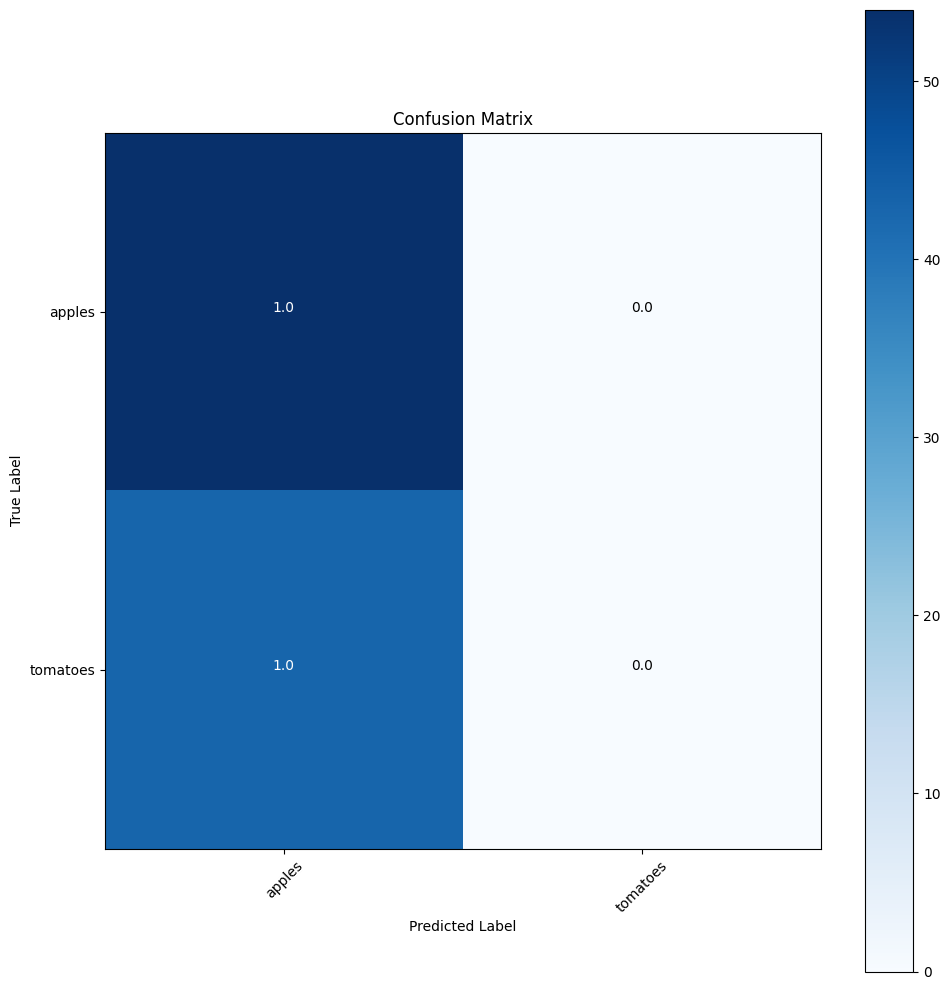

In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix', normalize=True)
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= target_names))

In [ ]:
import tensorflow as tf  # 딥러닝 프레임워크 TensorFlow를 불러옴
from tensorflow.keras.models import Sequential  # 레이어를 순차적으로 쌓는 간단한 모델 구조 제공
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization  # 신경망 기본 레이어들: 완전 연결, 과적합 방지, 정규화
from tensorflow.keras.callbacks import ModelCheckpoint  # 모델 성능이 좋을 때 자동 저장하는 기능 제공

# train_gen과 valid_gen은 이미지 데이터를 배치 단위로 제공하는 데이터 생성기라고 가정

img_size = (224, 224)  # 입력 이미지의 크기를 224x224 픽셀로 설정
channels = 3  # 컬러 이미지이므로 R,G,B → 채널 수는 3
img_shape = (img_size[0], img_size[1], channels)  # 전체 입력 형식 = (224, 224, 3)

class_count = len(list(train_gen.class_indices.keys()))  
# 학습 데이터에 있는 클래스(분류 대상)의 총 개수 계산 (예: 'apple', 'tomato' → 2)

# 사전 학습된 ResNet50 모델을 불러옴 (이미 ImageNet으로 학습된 가중치 사용)
base_model = tf.keras.applications.ResNet50(
    include_top=False,  # 기존 분류기 레이어는 제거하고 특징 추출기만 사용
    weights="imagenet",  # ImageNet으로 학습된 가중치를 불러옴
    input_shape=img_shape,  # 입력 이미지의 형식을 설정
    pooling='max'  # 마지막 출력에서 전체를 하나로 압축 (전역 최대 풀링)
)

# 기존 ResNet 모델의 가중치를 고정시켜서 학습되지 않도록 설정 (특징 추출기로만 사용)
for layer in base_model.layers:
    layer.trainable = False  # 가중치를 업데이트하지 않음

# 최종 모델 구성: 사전 학습 모델 위에 새로운 레이어를 쌓음
model = Sequential([
    base_model,                         # ResNet50 특징 추출기
    BatchNormalization(),              # 정규화 레이어: 학습 안정성 증가
    Dense(256, activation='relu'),     # 완전 연결층 (뉴런 256개), 활성화 함수는 ReLU
    Dropout(0.3),                      # 과적합 방지를 위한 드롭아웃 (30% 비활성화)
    Dense(64, activation='relu'),      # 또 다른 완전 연결층 (뉴런 64개)
    Dropout(0.3),                      # 다시 드롭아웃 적용
    Dense(class_count, activation='softmax')  # 출력층: 클래스 수 만큼 뉴런, 확률 출력을 위한 softmax 사용
])

# 모델 학습을 위한 최적화 알고리즘(Adam)을 정의
optimizer = tf.keras.optimizers.Adam()

# 모델을 학습할 준비를 함 (손실 함수, 최적화기, 평가 지표 설정)
model.compile(
    optimizer=optimizer,                 # Adam 최적화 알고리즘 사용
    loss='categorical_crossentropy',     # 다중 분류 문제이므로 crossentropy 사용
    metrics=['accuracy']                 # 모델의 성능을 정확도로 평가
)

# 모델 성능이 가장 좋을 때 저장할 파일 경로를 지정
filepath = 'best_model_resnet.h5'  # 저장될 모델 파일명

# 검증 정확도를 기준으로 가장 좋은 모델만 저장하도록 설정
checkpoint = ModelCheckpoint(
    filepath,                 # 저장 경로
    monitor='val_accuracy',  # 검증 데이터의 정확도를 기준으로 평가
    verbose=1,               # 모델 저장 여부를 콘솔에 출력
    save_best_only=True,     # 이전보다 성능이 좋을 경우에만 저장
    mode='max'               # 정확도 최대값 기준
)

# 모델을 학습시킴 (train_gen에서 데이터를 읽어와 20회 학습)
history = model.fit(
    x=train_gen,             # 학습 데이터 생성기
    epochs=100,               # 전체 데이터셋을 100번 반복 학습
    verbose=1,               # 학습 과정 자세히 출력
    validation_data=valid_gen,  # 검증용 데이터 생성기
    callbacks=[checkpoint]      # 최적 성능 모델을 저장하는 콜백 포함
)

In [8]:
import tensorflow as tf

# Load the .h5 model
model = tf.keras.models.load_model('best_model_resnet.h5')

# Save in SavedModel format
model.export('ResNet50_directory')

INFO:tensorflow:Assets written to: ResNet50_directory/assets


INFO:tensorflow:Assets written to: ResNet50_directory/assets


Saved artifact at 'ResNet50_directory'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  126748230106192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126748230104080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126748230104272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126748230104464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126748230103696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126748230106576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126750783789328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126750783784336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126750783785488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126750783786448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12675078378

In [19]:
import tensorflow as tf  # 딥러닝 프레임워크 TensorFlow를 불러옴
from tensorflow.keras.models import load_model, Model  # 저장된 모델을 불러오거나 모델을 다룰 수 있는 클래스
from tensorflow.keras.layers import Input, Average  # 모델 입력 설정과 여러 모델의 출력을 평균내는 레이어 (현재는 사용되지 않음)

# 학습 완료된 ResNet 기반 모델(best_model_resnet.h5)을 불러옴
model = load_model('best_model_resnet.h5')  # 이전에 저장해 둔 최고의 모델을 메모리에 불러옴

# 학습 데이터셋에 대해 모델의 손실값과 정확도를 평가함
train_score = model.evaluate(train_gen, steps=len(train_gen), verbose=1)
# steps: 전체 학습 데이터를 모두 평가하기 위한 배치 수
# verbose=1: 평가 과정을 자세히 출력함

# 검증 데이터셋에 대해 모델 성능 평가
valid_score = model.evaluate(valid_gen, steps=len(valid_gen), verbose=1)

# 테스트 데이터셋에 대해 최종 모델 성능 평가
test_score = model.evaluate(test_gen, steps=len(test_gen), verbose=1)

# 학습 데이터에서 손실(loss) 값 출력
print("Train Loss: ", train_score[0])
# 학습 데이터에서 정확도(accuracy) 출력
print("Train Accuracy: ", train_score[1])

# 구분선을 출력
print('-' * 20)

# 검증 데이터에서 손실 값 출력
print("Validation Loss: ", valid_score[0])
# 검증 데이터에서 정확도 출력
print("Validation Accuracy: ", valid_score[1])

# 다시 구분선 출력
print('-' * 20)

# 테스트 데이터에서 손실 값 출력
print("Test Loss: ", test_score[0])
# 테스트 데이터에서 정확도 출력
print("Test Accuracy: ", test_score[1])


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 532ms/step - accuracy: 0.9161 - loss: 0.2626
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7657 - loss: 0.5681   
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.8017 - loss: 0.4921   
Train Loss:  0.2847246825695038
Train Accuracy:  0.8983050584793091
--------------------
Validation Loss:  0.5775477290153503
Validation Accuracy:  0.7586206793785095
--------------------
Test Loss:  0.5810131430625916
Test Accuracy:  0.7525773048400879


In [22]:
model = load_model('best_model_resnet.h5')  
# 학습이 완료된 최상의 모델을 불러옴
# 이 모델은 학습 중 성능이 가장 좋았던 상태로 저장된 파일임

preds = model.predict(test_gen)  
# 테스트 데이터셋(test_gen)을 사용하여 모델의 예측 결과 생성
# predict_generator는 배치(batch) 단위로 데이터를 불러와 예측하는 함수
# 결과(preds)는 각 이미지에 대해 클래스별 확률값 배열로 나옴
# 예: [[0.1, 0.8, 0.1], [0.7, 0.2, 0.1], ...]

y_pred = np.argmax(preds, axis=1)  
# 확률값 중 가장 큰 값의 인덱스를 찾아서 실제 클래스 번호로 변환
# 위 예에서는 [1, 0]이 출력됨 (즉, 첫 번째 이미지는 클래스 1, 두 번째는 클래스 0으로 예측됨)

print(y_pred)  
# 최종 예측된 클래스 번호들을 출력
# 예: [1 0 2 1 1 0 ...]


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 0 1 1 0
 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1]


Confusion Matrix, Without Normalization
[[49  5]
 [19 24]]
              precision    recall  f1-score   support

      apples       0.72      0.91      0.80        54
    tomatoes       0.83      0.56      0.67        43

    accuracy                           0.75        97
   macro avg       0.77      0.73      0.73        97
weighted avg       0.77      0.75      0.74        97



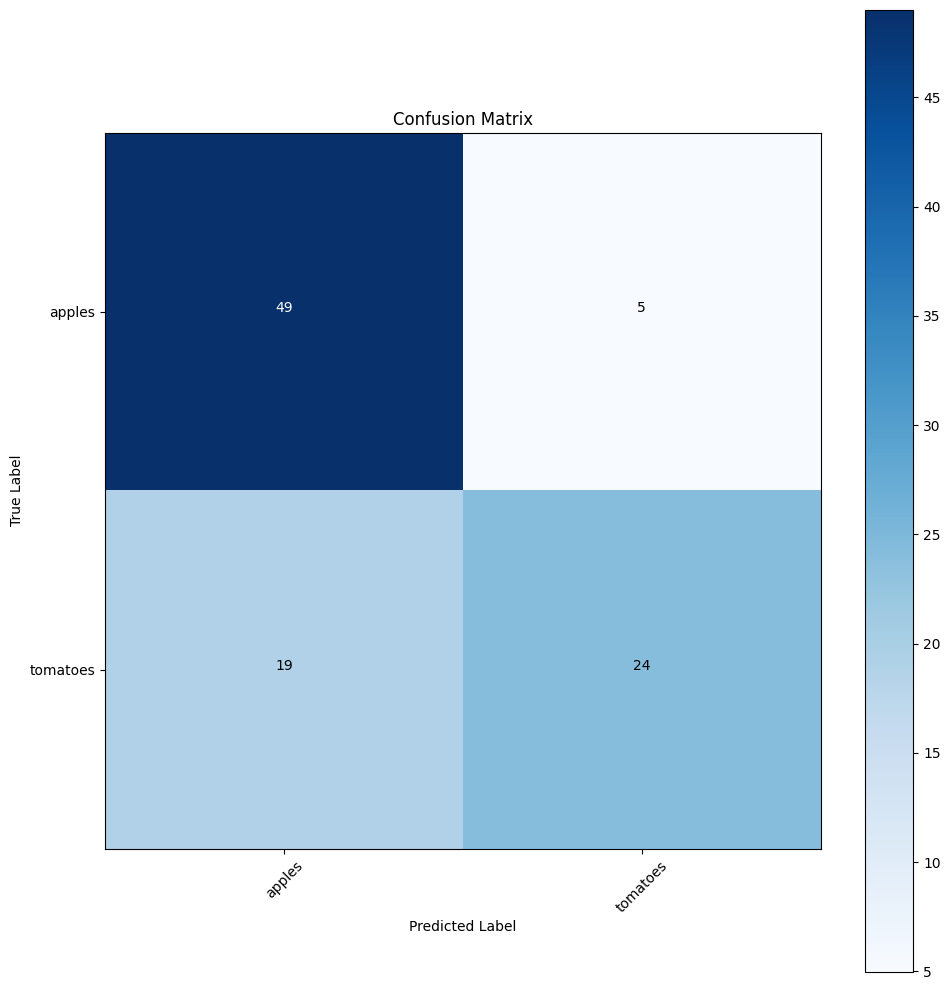

In [23]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= target_names))

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

# Check number of GPUs
gpus = tf.config.list_physical_devices('GPU')
print("GPUs detected:", len(gpus))  # e.g., 2

# Define parallel strategy
strategy = tf.distribute.MirroredStrategy()

# Assuming train_gen and valid_gen are your image data generators

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

with strategy.scope():
    # Create pre-trained model
    base_model = tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
    for layer in base_model.layers:
        layer.trainable = False
    model = Sequential([
        base_model,
        BatchNormalization(),
        Dense(256, activation='relu'),
        Dropout(0.3),
         Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(class_count, activation='softmax')
    ])
    
    optimizer = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define filepath to save the best model
filepath = 'best_model_vgg.h5'

# Create ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# Train the model with the added callback
history = model.fit(
    x=train_gen,
    epochs=100,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[checkpoint]
)

GPUs detected: 2
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


I0000 00:00:1747892347.159313    3798 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6144 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:02:00.0, compute capability: 8.6
I0000 00:00:1747892347.163478    3798 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6606 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step 


/home/kdh/anaconda3/envs/KSEB/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2025-05-22 05:39:15.424871: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: CANCELLED: GetNextFromShard was cancelled
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-05-22 05:39:15.424940: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: CANCELLED: GetNextFromShard was cancelled
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-05-22 05:39:15.425960: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: CANCELLED: GetNextFromShard was cancelled
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]] [type.googleapis.com/tensorflow.DerivedStatus='']


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Epoch 1/100
INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


I0000 00:00:1747892357.174875    3966 cuda_dnn.cc:529] Loaded cuDNN version 90501
I0000 00:00:1747892357.262086    3965 cuda_dnn.cc:529] Loaded cuDNN version 90501


4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.5592 - loss: 0.9762

2025-05-22 05:39:19.875153: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2025-05-22 05:39:22.495501: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]



Epoch 1: val_accuracy improved from -inf to 0.60345, saving model to best_model_vgg.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 896ms/step - accuracy: 0.5804 - loss: 0.9310 - val_accuracy: 0.6034 - val_loss: 0.7188
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.7450 - loss: 0.5666
Epoch 2: val_accuracy improved from 0.60345 to 0.63793, saving model to best_model_vgg.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 600ms/step - accuracy: 0.7480 - loss: 0.5651 - val_accuracy: 0.6379 - val_loss: 0.6329
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.8205 - loss: 0.4441

2025-05-22 05:39:27.419759: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]



Epoch 3: val_accuracy improved from 0.63793 to 0.70690, saving model to best_model_vgg.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step - accuracy: 0.8193 - loss: 0.4497 - val_accuracy: 0.7069 - val_loss: 0.5545
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.8756 - loss: 0.3177
Epoch 4: val_accuracy improved from 0.70690 to 0.74138, saving model to best_model_vgg.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 582ms/step - accuracy: 0.8730 - loss: 0.3273 - val_accuracy: 0.7414 - val_loss: 0.5293
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.8726 - loss: 0.3002
Epoch 5: val_accuracy improved from 0.74138 to 0.79310, saving model to best_model_vgg.h5


2025-05-22 05:39:34.279562: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 578ms/step - accuracy: 0.8719 - loss: 0.3032 - val_accuracy: 0.7931 - val_loss: 0.4951
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.8724 - loss: 0.2713
Epoch 6: val_accuracy improved from 0.79310 to 0.81034, saving model to best_model_vgg.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 574ms/step - accuracy: 0.8732 - loss: 0.2728 - val_accuracy: 0.8103 - val_loss: 0.4716
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.8802 - loss: 0.2991
Epoch 7: val_accuracy did not improve from 0.81034
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 559ms/step - accuracy: 0.8776 - loss: 0.3017 - val_accuracy: 0.8103 - val_loss: 0.4245
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.8810 - loss: 0.2449
Epoch 8: val_accuracy improved from 0.81034 to 0.87931, saving model to best_model_vgg.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 577ms/step - accuracy: 0.8811 - loss: 0.2456 - val_accuracy: 0.8793 - val_loss: 0.4193
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.8750 - loss: 0.2266
Epoch 9: val_accuracy did not improve from 0.87931
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 549ms/step - accuracy: 0.8774 - loss: 0.2254 - val_accuracy: 0.8448 - val_loss: 0.3925
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9000 - loss: 0.2130
Epoch 10: val_accuracy did not improve from 0.87931
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 540ms/step - accuracy: 0.9011 - loss: 0.2124 - val_accuracy: 0.8448 - val_loss: 0.4136
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.9051 - loss: 0.2455

2025-05-22 05:39:49.768835: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]



Epoch 11: val_accuracy did not improve from 0.87931
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 547ms/step - accuracy: 0.9089 - loss: 0.2349 - val_accuracy: 0.8448 - val_loss: 0.3912
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.9477 - loss: 0.1459
Epoch 12: val_accuracy improved from 0.87931 to 0.89655, saving model to best_model_vgg.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 585ms/step - accuracy: 0.9444 - loss: 0.1501 - val_accuracy: 0.8966 - val_loss: 0.3607
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.9340 - loss: 0.1407
Epoch 13: val_accuracy did not improve from 0.89655
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 585ms/step - accuracy: 0.9358 - loss: 0.1396 - val_accuracy: 0.8448 - val_loss: 0.3918
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.9475 - loss: 0.1385
Epoch 14: val_accuracy did not improve from 0.89655
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 563ms/step - accuracy: 0.9477 - loss: 0.1378 - val_accuracy: 0.8448 - val_loss: 0.3973
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.9172 - loss: 0.1657
Epoch 15: val_accuracy did not improve from 0.89655
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 548ms/step - accuracy: 0.9183 - loss: 0.1620 - val_accuracy: 0.8621 - val_loss: 0.4044
Epoch 16/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.9631 - loss: 0.0833
Epoch 16: val_accuracy did not improve f

2025-05-22 05:40:18.572612: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.9770 - loss: 0.0770
Epoch 22: val_accuracy did not improve from 0.89655
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 550ms/step - accuracy: 0.9773 - loss: 0.0800 - val_accuracy: 0.8621 - val_loss: 0.3865
Epoch 23/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9410 - loss: 0.1569
Epoch 23: val_accuracy did not improve from 0.89655
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 557ms/step - accuracy: 0.9416 - loss: 0.1531 - val_accuracy: 0.8621 - val_loss: 0.3765
Epoch 24/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.9760 - loss: 0.0613
Epoch 24: val_accuracy did not improve from 0.89655
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 556ms/step - accuracy: 0.9744 - loss: 0.0631 - val_accuracy: 0.8448 - val_loss: 0.3337
Epoch 25/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.9796 - loss: 0.0656
Epoch 25: val_accuracy did not improve from 0.89655
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 555ms/step - accuracy: 0.9809 - loss: 0.0633 - val_accuracy: 0.8448 - val_loss: 0.3862
E

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 585ms/step - accuracy: 0.9703 - loss: 0.0643 - val_accuracy: 0.9310 - val_loss: 0.3021
Epoch 29/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.9629 - loss: 0.0839
Epoch 29: val_accuracy did not improve from 0.93103
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 563ms/step - accuracy: 0.9627 - loss: 0.0848 - val_accuracy: 0.8448 - val_loss: 0.4793
Epoch 30/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.9966 - loss: 0.0746
Epoch 30: val_accuracy did not improve from 0.93103
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 553ms/step - accuracy: 0.9965 - loss: 0.0727 - val_accuracy: 0.9138 - val_loss: 0.2784
Epoch 31/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.9720 - loss: 0.0789
Epoch 31: val_accuracy did not improve from 0.93103
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 590ms/step - accuracy: 0.9703 - loss: 0.0796 - val_accuracy: 0.8621 - val_loss: 0.3394
Epoch 32/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9674 - loss: 0.0541
Epoch 32: val_accuracy did not improve f

2025-05-22 05:41:18.040397: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]



Epoch 43: val_accuracy did not improve from 0.93103
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 578ms/step - accuracy: 0.9689 - loss: 0.0730 - val_accuracy: 0.8793 - val_loss: 0.4456
Epoch 44/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.9889 - loss: 0.0392
Epoch 44: val_accuracy did not improve from 0.93103
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 570ms/step - accuracy: 0.9886 - loss: 0.0401 - val_accuracy: 0.8621 - val_loss: 0.5662
Epoch 45/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.9878 - loss: 0.0286
Epoch 45: val_accuracy did not improve from 0.93103
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 550ms/step - accuracy: 0.9877 - loss: 0.0295 - val_accuracy: 0.8793 - val_loss: 0.3735
Epoch 46/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.9934 - loss: 0.0190
Epoch 46: val_accuracy did not improve from 0.93103
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 598ms/step - accuracy: 0.9931 - loss: 0.0201 - val_accuracy: 0.8621 - val_loss: 0.7124
Epoch 47/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9816 - 

2025-05-22 05:43:14.821016: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.9992 - loss: 0.0040
Epoch 86: val_accuracy did not improve from 0.93103
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 549ms/step - accuracy: 0.9986 - loss: 0.0044 - val_accuracy: 0.8793 - val_loss: 0.9722
Epoch 87/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.9981 - loss: 0.0154
Epoch 87: val_accuracy did not improve from 0.93103
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 591ms/step - accuracy: 0.9977 - loss: 0.0164 - val_accuracy: 0.8448 - val_loss: 1.1003
Epoch 88/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.9938 - loss: 0.0303
Epoch 88: val_accuracy did not improve from 0.93103
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 590ms/step - accuracy: 0.9927 - loss: 0.0321 - val_accuracy: 0.8448 - val_loss: 0.9036
Epoch 89/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.9934 - loss: 0.0230
Epoch 89: val_accuracy did not improve from 0.93103
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 582ms/step - accuracy: 0.9931 - loss: 0.0229 - val_accuracy: 0.8793 - val_loss: 0.8018
E

In [7]:
import tensorflow as tf

# Load the .h5 model
model = tf.keras.models.load_model('best_model_vgg.h5')

# Save in SavedModel format
model.export('VGG16_directory')

INFO:tensorflow:Assets written to: VGG16_directory/assets


INFO:tensorflow:Assets written to: VGG16_directory/assets


Saved artifact at 'VGG16_directory'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  127081037357200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127081037357968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127081037352784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127081037355664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127081037355856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127081037360272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127081037356816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127081037358928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127081037362000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127081037363536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12708103735739

In [24]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average



model= load_model('best_model_vgg.h5')


train_score = model.evaluate(train_gen, steps= len(train_gen), verbose= 1)
valid_score = model.evaluate(valid_gen, steps= len(valid_gen), verbose= 1)
test_score = model.evaluate(test_gen, steps= len(test_gen), verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 347ms/step - accuracy: 0.9894 - loss: 0.0582
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step - accuracy: 0.8977 - loss: 0.3468
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step - accuracy: 0.8236 - loss: 0.4132
Train Loss:  0.062108974903821945
Train Accuracy:  0.9872881174087524
--------------------
Validation Loss:  0.3582693934440613
Validation Accuracy:  0.8965517282485962
--------------------
Test Loss:  0.38453245162963867
Test Accuracy:  0.8453608155250549


In [26]:
model = load_model('best_model_vgg.h5')
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
[1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0
 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1]


Confusion Matrix, Without Normalization
[[43 11]
 [ 4 39]]
              precision    recall  f1-score   support

      apples       0.91      0.80      0.85        54
    tomatoes       0.78      0.91      0.84        43

    accuracy                           0.85        97
   macro avg       0.85      0.85      0.85        97
weighted avg       0.86      0.85      0.85        97



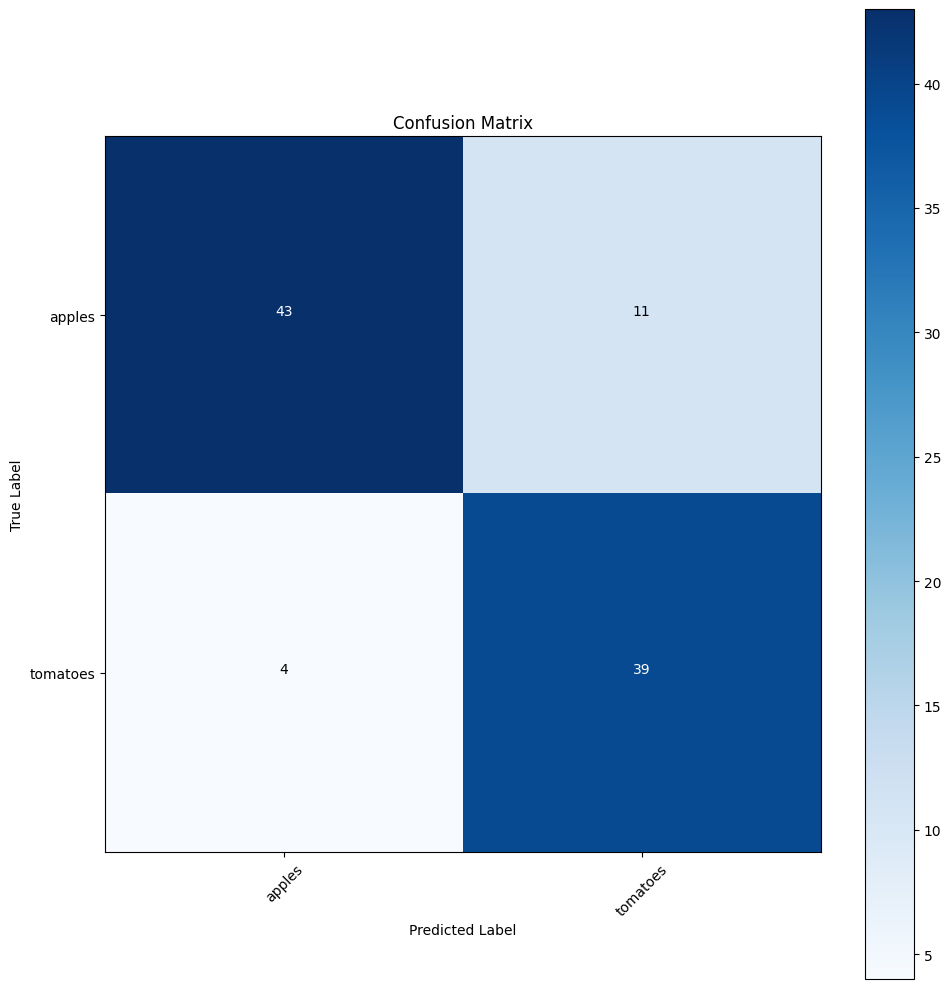

In [27]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= target_names))